# Notebook exploration Livrable 3
Le livrable 3 est composé de deux parties : 
    - dectéction d'anomalie
    - regroupement d'incident similaire

Cette présentation, détails les besoins du client (DGS) pour chacun des sous livrables : https://starclay-my.sharepoint.com/:p:/g/personal/rquillivic_starclay_fr/EUMr0n8i0XNEuaUMb5p7iMoBd7AiNKL5avi7hrZMm5Q4lQ?e=ZbuXPe

Ce notebook d'exploration à pour but de définir notre stratégie : 
- Construction d'un exemple d'une anomalie avec les prothèse PIP
- tests de différentes méthodes naives sur la détection de ce clusteur



## Chargement des données et des bibliothèques

In [18]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt



import spacy
import string
import nltk
from spacy.lang.fr.stop_words import STOP_WORDS 
from nltk.util import bigrams,everygrams

# gensim
import gensim
from gensim import corpora

from time import time
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')

from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim import models
import pyLDAvis
import clean_text

In [58]:
mrv = pd.read_csv("../data/data_mrv/declaration_mrv_complet.csv")

In [40]:
mrv['DCO'] = mrv.DCO.fillna('')
mrv_c = mrv[mrv['TYPE_DECLARANT']=='Citoyen']
mrv_c[mrv_c['DCO'].str.contains('PROTHESE MAMMAIRE IMPLANTABLE')]

,Unnamed: 0,NUMERO_DECLARATION,TYPE_DECLARATION,TYPE_DECLARANT,NB_PATIENT_CONCERNE,NB_DISPOSITIF_CONCERNE,DESCRIPTION_INCIDENT,ETAT_PATIENT,ACTION_PATIENT,DCO_ID,...,TDY_ID,TYPE_DYSFONCTIONNEMENT,CDY_ID,CONSEQUENCE_DYSFONCTIONNEMENT,TEF_ID,TYPE_EFFET,GRAVITE,NUMERO,TYPE_VIGILANCE,CLASSIFICATION
10396,10396,R1707350,CERFA,Citoyen,1.0,1.0,,"Nécessité d'explanter la prothèse , nettoyage ...",NaN,2965.0,...,D1636,DEGONF. / RUP. / DECOL. PATCH,NaN,NaN,E1148,DOULEUR,SEVER,R1707350,Matériovigilance,Autre type d'incident donnant lieu à un signal...
19414,19414,R1713816,CERFA,Citoyen,1.0,1.0,,..,..,2965.0,...,D1636,DEGONF. / RUP. / DECOL. PATCH,NaN,NaN,NaN,NaN,SEVER,R1713816,Matériovigilance,Autre type d'incident donnant lieu à un signal...
22557,22557,R1715631,CERFA,Citoyen,1.0,2.0,,..,..,2965.0,...,D1636,DEGONF. / RUP. / DECOL. PATCH,NaN,NaN,E1163,EXPLANTATION CONTROLATERALE PMI ROMPUE / PERSP,SEVER,R1715631,Matériovigilance,Autre type d'incident donnant lieu à un signal...
22558,22558,R1715637,CERFA,Citoyen,1.0,2.0,,..,..,2965.0,...,D1636,DEGONF. / RUP. / DECOL. PATCH,NaN,NaN,E1157,EPANCHEMENT / HEMATOME,SEVER,R1715637,Matériovigilance,Autre type d'incident donnant lieu à un signal...
23393,23393,R1716155,CERFA,Citoyen,NaN,2.0,,.,.,2965.0,...,D1636,DEGONF. / RUP. / DECOL. PATCH,NaN,NaN,E1148,DOULEUR,SEVER,R1716155,Matériovigilance,Autre type d'incident donnant lieu à un signal...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70970,70970,R1919652,CERFA,Citoyen,1.0,NaN,,"DOULEURS, LA PROTHESE DONNE DES SIGNES D'UNE C...",...,2965.0,...,NaN,NaN,NaN,NaN,E1475,ERYTHEME,MOYEN,R1919652,Matériovigilance,Autre type d'incident donnant lieu à un signal...
70971,70971,R1919652,CERFA,Citoyen,1.0,NaN,,"DOULEURS, LA PROTHESE DONNE DES SIGNES D'UNE C...",...,2965.0,...,NaN,NaN,NaN,NaN,E1124,BRULURE,MOYEN,R1919652,Matériovigilance,Autre type d'incident donnant lieu à un signal...
70972,70972,R1919652,CERFA,Citoyen,1.0,NaN,,"DOULEURS, LA PROTHESE DONNE DES SIGNES D'UNE C...",...,2965.0,...,NaN,NaN,NaN,NaN,E1135,COQUE,MOYEN,R1919652,Matériovigilance,Autre type d'incident donnant lieu à un signal...
70973,70973,R1919652,CERFA,Citoyen,1.0,NaN,,"DOULEURS, LA PROTHESE DONNE DES SIGNES D'UNE C...",...,2965.0,...,NaN,NaN,NaN,NaN,E1148,DOULEUR,MOYEN,R1919652,Matériovigilance,Autre type d'incident donnant lieu à un signal...


In [34]:
set(mrv['TYPE_DECLARANT'])

{'Citoyen', 'Etablissements et professionnels de santé'}

In [15]:
for col in ['DCO_ID','TEF_ID','TDY_ID','CDY_ID','GRAVITE'] :
    mrv[col] = mrv[col].fillna('')


le = LabelEncoder()
mrv['DCO_ID'] = le.fit_transform(mrv['DCO_ID'])
mrv['TEF_ID'] = le.fit_transform(mrv['TEF_ID'])
mrv['TDY_ID'] = le.fit_transform(mrv['TDY_ID'])
mrv['CDY_ID'] = le.fit_transform(mrv['CDY_ID'])
mrv['GRAVITE'] = le.fit_transform(mrv['GRAVITE'])

In [41]:
%%time
X = mrv[['DCO_ID','TEF_ID','TDY_ID','CDY_ID','GRAVITE']]
kmean = KMeans(100)
X_1000 =kmean.fit(X)

CPU times: user 2min 57s, sys: 1min 9s, total: 4min 6s
Wall time: 17.3 s


In [42]:
y = kmean.labels_

In [43]:
svd = TruncatedSVD(2)
X_2 = svd.fit_transform(X)


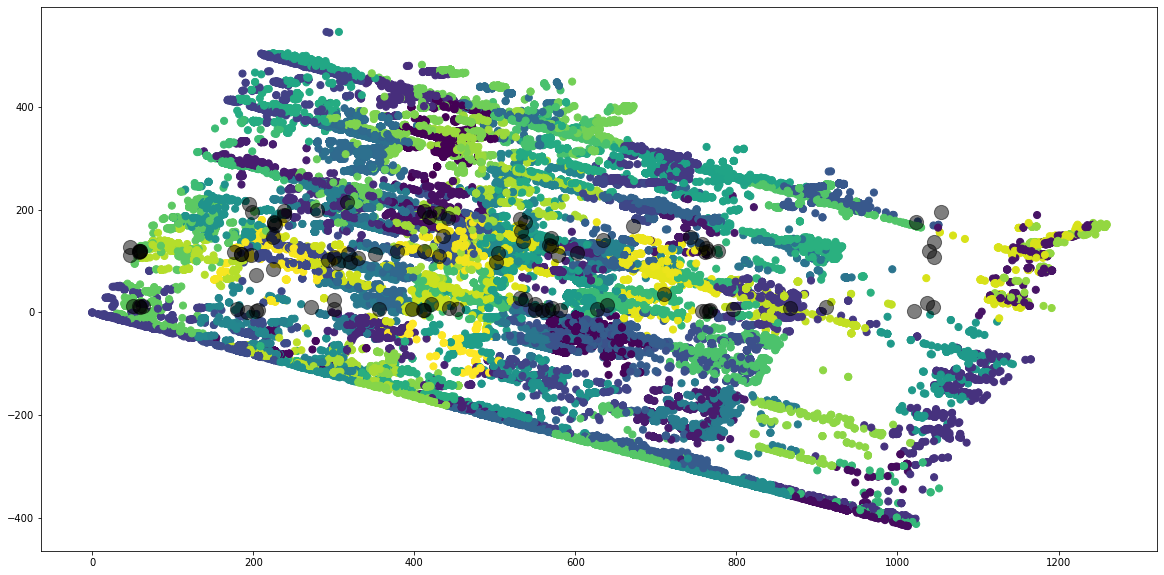

In [44]:
plt.figure(figsize = (20,10))
plt.scatter(X_2[:, 0], X_2[:, 1], c=y, s=50, cmap='viridis')

centers = kmean.cluster_centers_
        
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()

## Commentaire  :  BOF  ! 

## Approche LDA naive

In [77]:
np.mean([len(elt) for elt in Docs ])

45.12551654234998

In [59]:
%%time
mrv['DESCRIPTION_INCIDENT'] = mrv['DESCRIPTION_INCIDENT'].fillna('')


mrv['DESCRIPTION_INCIDENT'] = mrv['DESCRIPTION_INCIDENT'].map(lambda x : clean_text.preprocess_text(x))
Text = mrv['DESCRIPTION_INCIDENT'].values.tolist()

def nltk_tokenisation(text,sw=True,lang='french'):
    """
    Transforme le texte en liste de tokens, en miniscule, en ayant suprimé la  ponctuatiuon et les mots frequents
    Entrées
    - x::type:str
    Sortie:
    - tokens::type:list(str) liste de tokens
    - lemmas::type:list(str) liste des lemmes
    Exemple : Entrée = "je suis heureux aujourd'hui"; Sortie : ['je', 'suis', 'heureux', "aujourd'hui"]
    """
    txt = text.lower()
    if sw==False :
        tokens = nltk.word_tokenize(txt, language=lang, preserve_line=False)
    else : 
        words = nltk.word_tokenize(txt, language=lang, preserve_line=False)
        tokens = [word for word in words  if word not in set(STOP_WORDS|set(string.punctuation))]
    return(tokens)




Docs= [nltk_tokenisation(elt,sw=True,lang='french') for elt in Text]


CPU times: user 3min 20s, sys: 1.28 s, total: 3min 21s
Wall time: 3min 21s


In [60]:
np.mean([len(elt) for elt in Docs ])

33.68462977882891

In [70]:
bigram = gensim.models.Phrases(Docs,min_count=1, threshold=2)
texts = [bigram[line] for line in Docs]

In [71]:
texts[0]

['guide_resté', 'coincé_intérieur', 'sonde', 'bouger', 'changement_sonde']

In [61]:
%%time
# Création du dictionaire ou chaque uinque terme est associé à un index
dictionary = corpora.Dictionary(Docs)
dictionary.save('./LDA/dictionary_tokens_test.dict')
dictionary.filter_extremes(no_below=3, no_above=0.8, keep_n=100000)
# Conversion de la liste de document en une document-term matrice

# Approiche sac de mots
doc_term_matrix = [dictionary.doc2bow(doc) for doc in Docs]
corpora.MmCorpus.serialize('./LDA/corpus_tokens_bow_test.mm', doc_term_matrix)

# Approiche tf-idf
tfidf = models.TfidfModel(doc_term_matrix)
corpus_tfidf = tfidf[doc_term_matrix]
corpora.MmCorpus.serialize('./LDA/corpus_tokens_tfidf_test.mm', corpus_tfidf)

CPU times: user 47.5 s, sys: 1.59 s, total: 49.1 s
Wall time: 49.1 s


In [6]:
print(dictionary.num_docs,dictionary.num_nnz, dictionary.num_pos)

76954 2452482 3514818


In [79]:
print(dictionary.num_docs,dictionary.num_nnz, dictionary.num_pos)

76954 2607005 3472589


In [63]:
np.shape(corpus_tfidf)

(76954,)

In [62]:
%%time
# Création de l'objet LDA
Lda = gensim.models.ldamulticore.LdaMulticore

# Entrainement du modèle
ldamodel = Lda(doc_term_matrix, num_topics=100, id2word = dictionary, passes=15)

CPU times: user 10min 56s, sys: 5min, total: 15min 57s
Wall time: 31min 42s


In [63]:
import pyLDAvis.gensim
data = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

In [64]:
pyLDAvis.enable_notebook()

In [65]:
pyLDAvis.display(data)

In [66]:
pyLDAvis.show(data)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [31/Jul/2020 11:40:14] "GET / HTTP/1.0" 200 -
127.0.0.1 - - [31/Jul/2020 11:42:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 11:42:39] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 11:42:40] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 11:42:40] code 404, message Not Found
127.0.0.1 - - [31/Jul/2020 11:42:40] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [31/Jul/2020 11:42:41] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 11:44:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 11:44:04] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 11:44:05] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 11:44:05] code 404, message Not Found
127.0.0.1 - - [31/Jul/2020 11:44:05] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [31/Jul/2020 11:44:05] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...
